# Introduction

With all that you've learned, your SQL queries are getting pretty long, which can make them hard understand (and debug).

You are about to learn how to use **AS** and **WITH** to tidy up your queries and make them easier to read.

Along the way, we'll use the familiar `pets` table, but now it includes the ages of the animals.
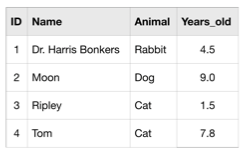

# AS

ou learned in an earlier tutorial how to use **AS** to rename the columns generated by your queries, which is also known as **aliasing**. This is similar to how Python uses as for aliasing when doing imports like import pandas as pd or import seaborn as sns.

To use **AS** in SQL, insert it right after the column you select. Here's an example of a query without an **AS** clause:
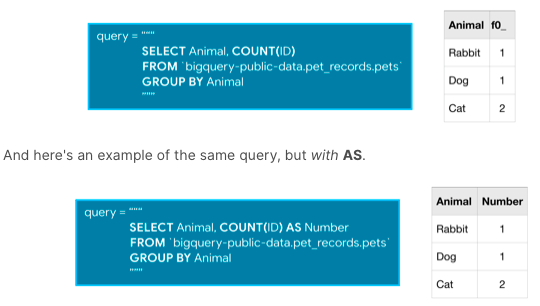

These queries return the same information, but in the second query the column returned by the **COUNT()** function will be called `Number`, rather than the default name of `f0__`.

# WITH ... AS

On its own, **AS** is a convenient way to clean up the data returned by your query. It's even more powerful when combined with **WITH** in what's called a "common table expression".

A **common table expression** (or **CTE**) is a temporary table that you return within your query. CTEs are helpful for splitting your queries into readable chunks, and you can write queries against them.

For instance, you might want to use the pets table to ask questions about older animals in particular. So you can start by creating a CTE which only contains information about animals more than five years old like this:
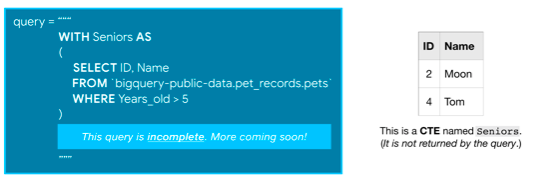

While this incomplete query above won't return anything, it creates a CTE that we can then refer to (as `Seniors`) while writing the rest of the query.

We can finish the query by pulling the information that we want from the CTE. The complete query below first creates the CTE, and then returns all of the IDs from it.
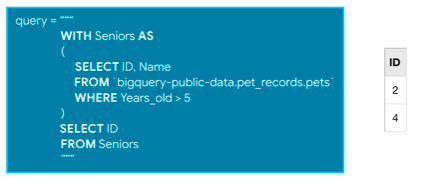
You could do this without a CTE, but if this were the first part of a very long query, removing the CTE would make it much harder to follow.

Also, it's important to note that CTEs only exist inside the query where you create them, and you can't reference them in later queries. So, any query that uses a CTE is always broken into two parts: (1) first, we create the CTE, and then (2) we write a query that uses the CTE.

## Example: How many Bitcoin transactions are made per month?

We're going to use a CTE to find out how many Bitcoin transactions were made each day for the entire timespan of a bitcoin transaction dataset.

We'll investigate the `transactions` table. Here is a view of the first few rows.

In [11]:
from google.cloud import bigquery

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/macbookpro/Documents/5. Kaggle/3. SQL/orbital-caldron-272723-ed30f065fd90.json"

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("transactions")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "transactions" table
#client.list_rows(table, max_results=5).to_dataframe()

Since the `block_timestamp` column contains the date of each transaction in DATETIME format, we'll convert these into DATE format using the **DATE()** command.

We do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first.

In [12]:
# Query to select the number of transactions per date, sorted by date
query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions,
                        trans_date
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()

,transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


# Exercise
You'll work with a dataset about taxi trips in the city of Chicago. Run the cell below to fetch the `chicago_taxi_trips` dataset.
You are curious how much slower traffic moves when traffic volume is high. This involves a few steps.

In [18]:
from google.cloud import bigquery

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/macbookpro/Documents/5. Kaggle/3. SQL/orbital-caldron-272723-ed30f065fd90.json"

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "chicago_taxi_trips" dataset
dataset_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)


### 1) Find the data
Before you can access the data, you need to find the table name with the data.

*Hint*: Tab completion is helpful whenever you can't remember a command. Type `client.` and then hit the tab key. Don't forget the period before hitting tab.

In [20]:
# List all the tables in the dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset (there is only one!)
for table in tables:  
    print(table.table_id)


taxi_trips


### 2) Peek at the data

Inspect the data and see if any issues with data quality are immediately obvious. 

In [23]:
# Construct a reference to the "taxi_trips" table
table_ref = dataset_ref.table("taxi_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "taxi_trips" table
client.list_rows(table, max_results=5).to_dataframe()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,aa97e0c41406353dec00f7743aed35b739528a35,d88fbc7bc71b56a99d9bb8498ae49e071a50699ba66aba...,2013-06-17 12:15:00+00:00,2013-06-17 12:15:00+00:00,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,18.30,Credit Card,Chicago Elite Cab Corp.,NaN,NaN,None,NaN,NaN,None
1,8ae1e34ba09e91621528852f7c200d8ce15268d1,6e0a0360a9107f3cc0064a80f49f33a7f53e8aa6232d66...,2013-06-16 04:15:00+00:00,2013-06-16 04:15:00+00:00,660.0,0.0,NaN,NaN,NaN,NaN,...,0.0,15.25,No Charge,Taxi Affiliation Services,NaN,NaN,None,NaN,NaN,None
2,a1022dad043c86d56cc8eea5c6a1f49f90a13b8b,f7f256ad067dd0ea9223b394b4a802ccf1ede42fe18951...,2013-06-14 13:00:00+00:00,2013-06-14 13:00:00+00:00,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,8.25,Credit Card,Taxi Affiliation Services,NaN,NaN,None,NaN,NaN,None
3,bcab8040b4d99dcfbde88881e436e399d40b6737,101852f8d24207a0fbe76e94171aaa995b94a2d71e995e...,2013-06-14 17:15:00+00:00,2013-06-14 17:15:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,...,0.0,44.65,Credit Card,Taxi Affiliation Services,NaN,NaN,None,NaN,NaN,None
4,a4e3347558fe61509e35115aa576f1c7e187587a,21c5d83c2cb73035c6c4d35da452ff1714aff86f5efb32...,2013-08-23 23:30:00+00:00,2013-08-23 23:30:00+00:00,360.0,1.3,NaN,NaN,NaN,NaN,...,0.0,7.05,Credit Card,Choice Taxi Association,NaN,NaN,None,NaN,NaN,None


Some trips in the top few rows have `trip_seconds` or `trip_miles` values of 0. Other location fields have values of `None`. That is a problem if we want to use those fields.

### 3) Determine when this data is from

If the data is sufficiently old, we might be careful before assuming the data is still relevant to traffic patterns today. Write a query that counts the number of trips in each year.  

Your results should have two columns:
- `year` - the year of the trips
- `num_trips` - the number of trips in that year

Hints:
- When using **GROUP BY** and **ORDER BY**, you should refer to the columns by the alias `year` that you set at the top of the **SELECT** query.
- The SQL code to **SELECT** the year from `trip_start_timestamp` is <code>SELECT EXTRACT(YEAR FROM trip_start_timestamp)</code>
- The **FROM** field can be a little tricky until you are used to it.  The format is:
    1. A backick (the symbol \`).
    2. The project name. In this case it is `bigquery-public-data`.
    3. A period.
    4. The dataset name. In this case, it is `chicago_taxi_trips`.
    5. A period.
    6. The table name. You used this as your answer in **1) Find the data**.
    7. A backtick (the symbol \`).

In [32]:
rides_per_year_query = """
                        SELECT EXTRACT(YEAR FROM trip_start_timestamp) AS year,
                            COUNT(1) AS num_trips
                        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                        GROUP BY year
                        ORDER BY year
                       """

# Set up the query (cancel the query if it would use too much of 
# your quota)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
rides_per_year_query_job = client.query(rides_per_year_query, job_config=safe_config)

# API request - run the query, and return a pandas DataFrame
rides_per_year_result = rides_per_year_query_job.to_dataframe()

# Print the DataFrame
rides_per_year_result

,year,num_trips
0,2013,27217716
1,2014,37395436
2,2015,32385875
3,2016,31759339
4,2017,24988003
5,2018,20732088
6,2019,16477365
7,2020,2195630


### 4) Dive slightly deeper

You'd like to take a closer look at rides from 2017.  Copy the query you used above in `rides_per_year_query` into the cell below for `rides_per_month_query`.  Then modify it in two ways:
1. Use a **WHERE** clause to limit the query to data from 2017.
2. Modify the query to extract the month rather than the year.

In [36]:
rides_per_month_query = """
                        SELECT EXTRACT(MONTH FROM trip_start_timestamp) AS month,
                            COUNT(1) AS num_trips
                        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                        WHERE EXTRACT(YEAR FROM trip_start_timestamp)=2017
                        GROUP BY month
                        ORDER BY month
                       """
# Set up the query (cancel the query if it would use too much of 
# your quota)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
rides_per_month_query_job = client.query(rides_per_month_query, job_config=safe_config)

# API request - run the query, and return a pandas DataFrame
rides_per_month_result = rides_per_month_query_job.to_dataframe()

# Print the DataFrame
rides_per_month_result

,month,num_trips
0,1,1972071
1,2,1909802
2,3,2362105
3,4,2194702
4,5,2323386
5,6,2324472
6,7,2054299
7,8,2079861
8,9,1950631
9,10,2141197


### 5) Write the query

It's time to step up the sophistication of your queries.  Write a query that shows, for each hour of the day in the dataset, the corresponding number of trips and average speed.

Your results should have three columns:
- `hour_of_day` - sort by this column, which holds the result of extracting the hour from `trip_start_timestamp`.
- `num_trips` - the count of the total number of trips in each hour of the day (e.g. how many trips were started between 6AM and 7AM, independent of which day it occurred on).
- `avg_mph` - the average speed, measured in miles per hour, for trips that started in that hour of the day.  Average speed in miles per hour is calculated as `3600 * SUM(trip_miles) / SUM(trip_seconds)`. (The value 3600 is used to convert from seconds to hours.)

Restrict your query to data meeting the following criteria:
- a `trip_start_timestamp` between **2017-01-01** and **2017-07-01**
- `trip_seconds` > 0 and `trip_miles` > 0

You will use a common table expression (CTE) to select just the relevant rides.  Because this dataset is very big, this CTE should select only the columns you'll need to create the final output (though you won't actually create those in the CTE -- instead you'll create those in the later **SELECT** statement below the CTE).

In [40]:
speeds_query = """
               WITH RelevantRides AS
               (
                   SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day, 
                          trip_miles, 
                          trip_seconds
                   FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                   WHERE trip_start_timestamp > '2017-01-01' AND 
                         trip_start_timestamp < '2017-07-01' AND 
                         trip_seconds > 0 AND 
                         trip_miles > 0
               )
               SELECT hour_of_day, 
                      COUNT(1) AS num_trips, 
                      3600 * SUM(trip_miles) / SUM(trip_seconds) AS avg_mph
               FROM RelevantRides
               GROUP BY hour_of_day
               ORDER BY hour_of_day
               """

# Set up the query (cancel the query if it would use too much of your quota)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
speeds_query_job = client.query(speeds_query, job_config=safe_config)

# API request - run the query, and return a pandas DataFrame
speeds_result = speeds_query_job.to_dataframe()

# View results
print(speeds_result)

    hour_of_day  num_trips    avg_mph
0             0     319339  20.230524
1             1     266529  18.937621
2             2     210147  18.777070
3             3     159668  20.158048
4             4     122183  26.736014
5             5     119312  30.769172
6             6     182738  24.588313
7             7     358406  17.735967
8             8     541775  15.079892
9             9     565548  16.543882
10           10     525120  18.539614
11           11     594603  18.928379
12           12     622324  17.838745
13           13     630181  17.671089
14           14     622465  16.974239
15           15     640430  15.688418
16           16     701435  14.283888
17           17     756627  12.462955
18           18     768251  13.646810
19           19     701064  16.642882
20           20     598614  19.536777
21           21     552726  20.433874
22           22     501095  19.531374
23           23     399587  19.877046
